In [61]:
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.optimize import brentq as find_root

In [24]:
SIGMA_LAYER = 25.8  # kg/m^3; potential density of isopycnal surface to find the depth of
MLD_THRESHOLD = 0.1  # kg/m^3; threshold for mixed layer depth calculation

In [25]:
DATA_DIRECTORY = Path("../data")
CE09_OSPM_FILE = DATA_DIRECTORY / "ce09ospm_gridded_profiles.nc"

ce09 = xr.open_dataset(CE09_OSPM_FILE)
ce09 = ce09.squeeze().load()
ce09 = ce09.swap_dims({"pressure": "depth"})
# backfill surface data for identifying surface sigma_0, but limit to 5 m depth (10 data points at 0.5 m intervals)
ce09_bfill = ce09.bfill("depth", limit=10)
ce09["threshold_sigma_0"] = ce09_bfill["potential_density"].isel(depth=0) + MLD_THRESHOLD

In [71]:
def calculate_mld(depth: np.ndarray, z: np.ndarray, sigma_0: np.ndarray, surface_sigma_0: float) -> float:
    """Calculate mixed layer depth for a single time step.

    Args:
        depth (np.ndarray): Array of depths at which to calculate the mixed layer depth.
        z (np.ndarray): Array of depths corresponding to sigma_0.
        sigma_0 (np.ndarray): Array of sigma_0 values.
        surface_sigma_0 (float): Surface sigma_0 value.

    Returns:
        float: Mixed layer depth.

    """
    mld = np.interp(depth, z, sigma_0, left=np.nan, right=np.nan) - surface_sigma_0
    return float(mld)


mld = np.empty(ce09["time"].size) * np.nan
sigma_layer_depth = np.empty(ce09["time"].size) * np.nan

for i, (sigma_0, surface_sigma_0) in enumerate(
    zip(
        ce09["potential_density"].isel(depth=slice(None)).to_numpy().T,
        ce09["threshold_sigma_0"].to_numpy(),
        strict=True,
    ),
):
    z = ce09["depth"].to_numpy()[~np.isnan(sigma_0)]
    sigma_0_filtered = sigma_0[~np.isnan(sigma_0)]
    try:
        mld[i] = find_root(
            partial(
                calculate_mld,
                z=z,
                sigma_0=sigma_0_filtered,
                surface_sigma_0=surface_sigma_0,
            ),
            np.min(z),
            np.max(z),
        )
    except ValueError:
        mld[i] = np.nan
    try:
        sigma_layer_depth[i] = find_root(
            partial(
                calculate_mld,
                z=z,
                sigma_0=sigma_0_filtered,
                surface_sigma_0=SIGMA_LAYER,
            ),
            np.min(z),
            np.max(z),
        )
    except ValueError:
        sigma_layer_depth[i] = np.nan

sigma_at_mld = ce09["potential_density"].interp(depth=xr.DataArray(mld, dims="time"))

In [72]:
ce09

<xarray.Dataset> Size: 60MB
Dimensions:            (depth: 961, time: 3876)
Coordinates:
  * depth              (depth) float32 4kB 29.75 30.25 30.74 ... 504.7 505.2
  * time               (time) datetime64[ns] 31kB 2014-10-08T12:00:00 ... 202...
    latitude           float32 4B 46.85
    longitude          float32 4B 235.0
    pressure           (depth) float32 4kB 30.0 30.5 31.0 ... 509.0 509.5 510.0
Data variables:
    temperature        (depth, time) float32 15MB nan nan nan ... 5.292 nan nan
    salinity           (depth, time) float32 15MB nan nan nan ... 34.09 nan nan
    potential_density  (depth, time) float32 15MB nan nan nan ... 26.93 nan nan
    dissolved_oxygen   (depth, time) float32 15MB nan nan nan ... 30.65 nan nan
    threshold_sigma_0  (time) float32 16kB 24.69 24.85 24.85 ... 24.96 24.97
Attributes: (12/67)
    title:                           CE09OSPM CTD and Dissolved Oxygen Data: ...
    summary:                         This file contains profiler data collect...
    date_created:                    2025-06-09T17:23:37
    history:                         Created: 2025-06-09T17:23:37
    keywords:                        OSU, NSF, OOI, CE09OSPM, endurance array...
    keyword_vocabulary:              GCMD
    ...                              ...
    keywords_vocabulary:             GCMD Science Keywords
    date_modified:                   2025-06-09T00:00:00Z
    date_issued:                     2025-06-09T00:00:00Z
    geospatial_vertical_units:       dbar
    geospatial_vertical_resolution:  0.5 dbar
    geospatial_vertical_positive:    down

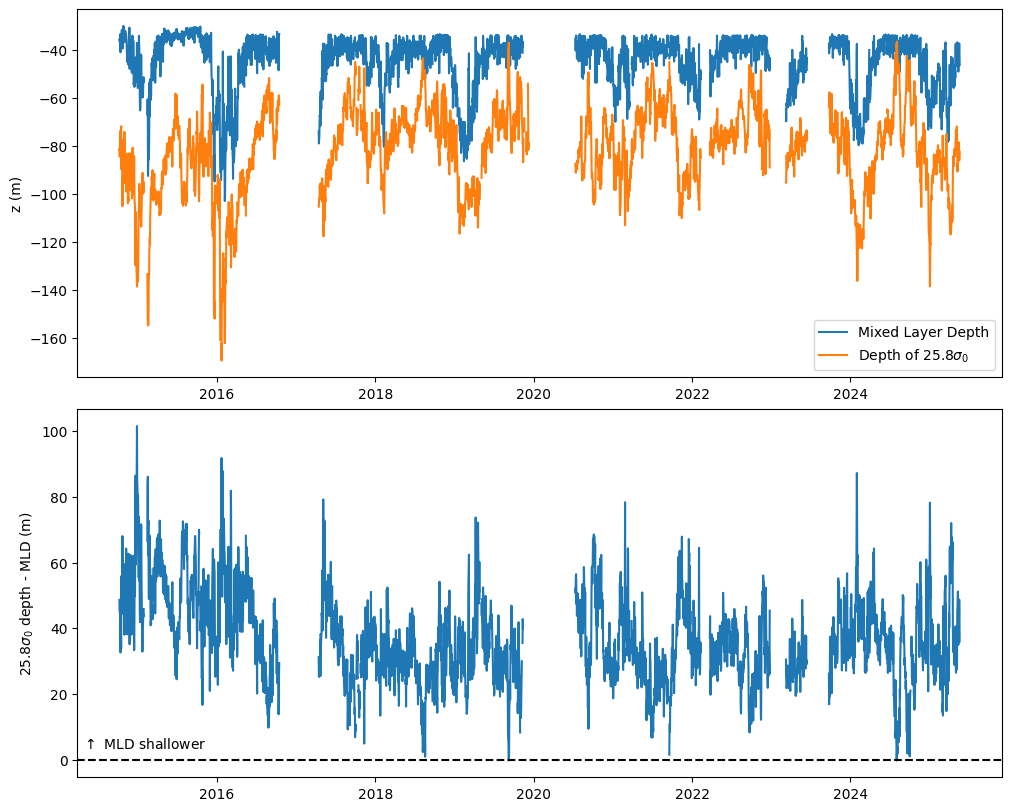

In [73]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout="constrained")
ax1: plt.Axes = axs[0]
ax2: plt.Axes = axs[1]

ax1.plot(ce09["time"], -mld, label="Mixed Layer Depth")
ax1.plot(ce09["time"], -sigma_layer_depth, label=f"Depth of {SIGMA_LAYER}$\\sigma_0$")
ax1.set_ylabel("z (m)")
ax1.legend()

ax2.plot(ce09["time"], sigma_layer_depth - mld)
ax2.set_ylabel(f"{SIGMA_LAYER}$\\sigma_0$ depth - MLD (m)")
ax2.annotate(
    "$\\uparrow$ MLD shallower",
    xy=(0.005, 0.08),
    xycoords="axes fraction",
    ha="left",
)
ax2.axhline(0, color="k", linestyle="--")

plt.savefig("../misc/wa_profiler_mld_sigma_layer_depth.png", dpi=300)

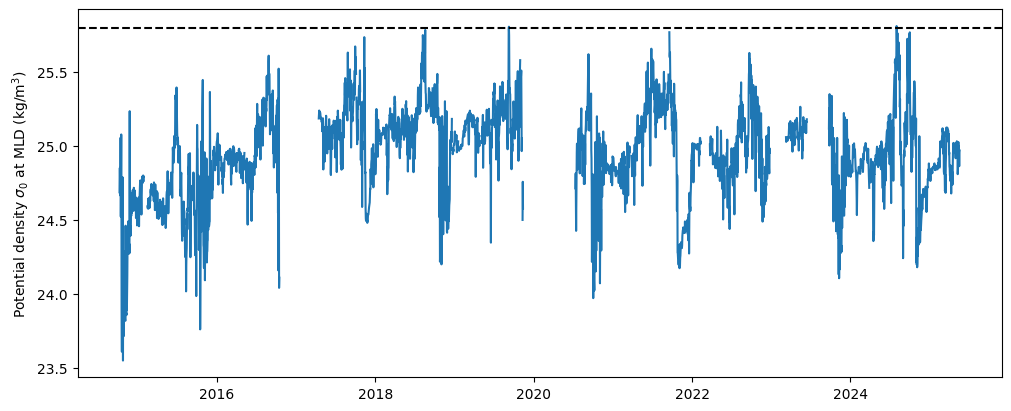

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout="constrained")

ax.plot(ce09["time"], sigma_at_mld)
ax.set_ylabel("Potential density $\\sigma_0$ at MLD (kg/m$^3$)")
ax.axhline(SIGMA_LAYER, color="k", linestyle="--")
plt.savefig("../misc/wa_profiler_sigma_at_mld.png", dpi=300)

## Comparison to Oceanic Pathways model